In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv
import torch
from torch import nn
import torch.nn.functional as F
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from lib.constants import AMINO_ACID_MAP, AMINO_ACID_MAP_INV
from lib.across_window_utils import (
    get_phi_psi_dist_window, get_afs_window, get_xrays_window, get_cluster_medoid, find_clusters,
    precompute_dists, filter_precomputed_dists, 
)
from collections import defaultdict
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'

In [3]:
from matplotlib.patches import ConnectionPatch

def plot(q, seq_ctxt, xrays, afs, clusters, phi_psi_dist, precomputed_dists):
    n_cluster_plot = 10
    n_clusters = len(np.unique(clusters))
    xrays = xrays.reshape(2, -1)
    afs = afs.reshape(2, -1)
    print(pd.Series(clusters).value_counts())

    cluster_points = phi_psi_dist.groupby(clusters).count().sort_values('phi_0', ascending=False).index.values
    clusters_plot = cluster_points[:n_cluster_plot]
    medoids = []
    for cluster in cluster_points:
        medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, clusters, cluster)
        medoids.append(medoid)
    medoids = np.array(medoids)

    colors = sns.color_palette('Dark2', n_clusters)
    fig, axes = plt.subplots(len(clusters_plot), q.winsize, figsize=(16, min(n_cluster_plot, len(clusters_plot))*4), sharey=True, sharex=True)
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    for i,axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            cluster_dist = phi_psi_dist[clusters == clusters_plot[i]]

            sns.scatterplot(data=phi_psi_dist[clusters != clusters_plot[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
            sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters_plot[i]}', color=colors[i])
            ax.scatter(xrays[0,j], xrays[1,j], color='tab:red', marker='X', label='X-ray', zorder=1000)
            ax.scatter(afs[0,j], afs[1,j], color='tab:orange', marker='X', label='AF', zorder=1000)
            # ax.scatter(pred[0,j], pred[1,j], color='tab:orange', marker='X', label=pred_id, zorder=1000)
            ax.scatter(medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j], color='black', marker='X', label='Cluster Centroid', zorder=1000)

            def add_conn(xyA, xyB, color, lw, **kwargs):
                con = ConnectionPatch(
                    xyA=xyA, 
                    xyB=xyB, 
                    coordsA="data", coordsB="data", 
                    axesA=axrow[j], axesB=axrow[j+1], 
                    color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
                )
                fig.add_artist(con)
            if j < q.winsize - 1:
                # TODO draw lines for 50 points closest to centroid
                for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                    add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
                add_conn((xrays[0,j], xrays[1,j]), (xrays[0,j+1], xrays[1,j+1]), 'tab:red', 5, zorder=100)
                add_conn((afs[0,j], afs[1,j]), (afs[0,j+1], afs[1,j+1]), 'tab:orange', 5, zorder=100)
                # add_conn((pred[0,j], pred[1,j]), (pred[0,j+1], pred[1,j+1]), 'tab:orange', 5, zorder=100)
                add_conn((medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j]), (medoids[i].reshape(2,-1)[0,j+1], medoids[i].reshape(2,-1)[1,j+1]), 'black', 5, zorder=100)

            ax.set_xlim(-180, 180)
            ax.set_ylim(-180, 180)
            ax.set_xlabel('')
            if j == q.winsize - 1:
                ax.legend()
            else:
                ax.legend().remove()
            if j == 0:
                ax.set_ylabel(f'Cluster {clusters_plot[i]} [{cluster_dist.shape[0]}]')
    fig.supxlabel('Phi')
    fig.supylabel('Psi')
    # fig.suptitle(
    #     # f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_sil:.2f}, Prediction Score [Cluster {nearest_cluster_pred}]: {pred_sil:.2f}', 
    #     f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} ({n_unassigned} unassigned) Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_maha:.2f}', 
    #     y=1.01
    # )
    plt.tight_layout()
    plt.show()

In [9]:
import json
pdb_codes = json.load(open('proteins.json'))
ml_data = [f.name.split('_')[0] for f in Path('ml_data').iterdir()]
for pdb_code in pdb_codes[::-1]:
    if pdb_code in ml_data:
        print(pdb_code)
        break
pdb_codes.index(pdb_code)

5NUP


646

In [16]:
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]
ml_samples = [f.stem for f in Path('ml_samples/medoids-v2').iterdir()]
for pdb_code in pdb_codes[::-1]:
    if pdb_code in ml_samples:
        print(pdb_code)
        break
pdb_codes.index(pdb_code)

6CJ0


918

In [19]:
len(set(pdb_codes) - set(ml_samples))

310

In [5]:
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]
winsizes = [4,5,6,7]
outdir = Path(f'ml_samples/medoids-v2')
outdir.mkdir(exist_ok=True, parents=True)
X_lens = [5, 3, 2] #[15, 5, 3, 2]

for id in pdb_codes:
    if (outdir / f'{id}.pt').exists():
        print('Skipping', id)
        continue
    try:
        da = MultiWindowQuery(id, winsizes, PDBMINE_URL, PROJECT_DIR)
        da.load_results()
    except FileNotFoundError as e:
        print(e)
        continue
    if da.af_phi_psi is None:
        continue
    print(id)

    # SKIP FIRST WINDOW SIZE
    da.winsizes = da.winsizes[1:]
    da.queries = da.queries[1:]

    center_idx_ctxt = da.queries[-1].get_center_idx_pos()
    winsize_ctxt = da.queries[-1].winsize
    # seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]
    # seqs_for_window = pd.DataFrame({'seq_ctxt': seqs_for_window})
    seqs = da.xray_phi_psi[['seq_ctxt', 'pos']]
    seqs = seqs[~seqs.seq_ctxt.str.contains('X')]
    seqs = seqs.drop_duplicates('seq_ctxt')
    seqs = seqs[seqs.seq_ctxt.isin(da.af_phi_psi.seq_ctxt)]
    seqs = seqs.rename(columns={'seq_ctxt': 'seq'})

    if seqs.shape[0] == 0:
        print('No sequences for', id)
        continue
    print(seqs.shape, seqs.seq.nunique())

    x_medoids = defaultdict(list)
    x_af = defaultdict(list)
    x_res = []
    y = []
    pos = []
    seqs_ = []

    for i,row in tqdm(seqs.iterrows()):
        # Check if alphafold data is complete for largest window size
        afs = get_afs_window(da, da.queries[-1], row.seq)
        if (afs is None) or (afs.shape[0] != da.queries[-1].winsize*2) or (np.isnan(afs).any()):
            # print(f"AF data for {row.seq} is incomplete")
            continue
        # Check if xrays are complete for largest window size
        xrays = get_xrays_window(da, da.queries[-1], row.seq)
        if xrays.shape[0] != da.queries[-1].winsize*2 or np.isnan(xrays).any():
            # print(f"Xray data for {row.seq} is incomplete")
            continue
        for j,q in enumerate(da.queries):
            xrays = get_xrays_window(da, q, row.seq)
            afs = get_afs_window(da, q, row.seq)
            phi_psi_dist = get_phi_psi_dist_window(q, row.seq)
            skip = False

            phi_psi_dist = phi_psi_dist.dropna()
            phi_psi_dist = phi_psi_dist[(phi_psi_dist <= 180).all(axis=1)]
            
            if phi_psi_dist.shape[0] == 0:
                # print(f"No pdbmine data for {row.seq}")
                skip = True
            if phi_psi_dist.shape[1] != q.winsize*2:
                # print(f"Phi/Psi data for {row.seq} is incomplete")
                skip = True
            if phi_psi_dist.shape[0] > 10000:
                phi_psi_dist = phi_psi_dist.sample(10000)
            
            medoids = np.zeros([X_lens[j], q.winsize*2])

            if not skip and phi_psi_dist.shape[0] == 1:
                medoids[0] = phi_psi_dist.iloc[0].values
            elif not skip and phi_psi_dist.shape[0] > 1:
                # Cluster
                dists = precompute_dists(phi_psi_dist)
                n_clusters, clusters = find_clusters(dists, min_cluster_size=np.min([phi_psi_dist.shape[0], 20]), cluster_selection_epsilon=30)

                if n_clusters == 0:
                    n_clusters, clusters = find_clusters(dists, min_cluster_size=2, cluster_selection_epsilon=60)
                
                if n_clusters == 0:
                    n_clusters, clusters = find_clusters(dists, min_cluster_size=2, cluster_selection_epsilon=120)
                
                if n_clusters > 0:
                    dists, phi_psi_dist, clusters = filter_precomputed_dists(dists, phi_psi_dist, clusters)
                    cluster_counts = pd.Series(clusters).value_counts().sort_values(ascending=False)
                    for k,cluster in zip(range(X_lens[j]), cluster_counts.index):
                        medoid = get_cluster_medoid(phi_psi_dist, dists, clusters, cluster)
                        medoids[k] = medoid

            x_medoids[j].append(torch.tensor(medoids, dtype=torch.float32))
            x_af[j].append(torch.tensor(afs, dtype=torch.float32))
        pos.append(row.pos)
        seqs_.append(row.seq)
        x_res.append(AMINO_ACID_MAP[row.seq[center_idx_ctxt]])
        # y.append(torch.tensor(xrays.reshape(2, -1)[:, center_idx_ctxt], dtype=torch.float32))
        y.append(torch.tensor(xrays, dtype=torch.float32))
        if torch.isnan(y[-1]).any():
            print('Xray data is nan for', row.seq)

    if len(y) == 0:
        print('No data for', id)
        continue
    for i in range(len(da.queries)):
        x_medoids[i] = torch.stack(x_medoids[i])
        x_af[i] = torch.stack(x_af[i])

    x_res = F.one_hot(torch.tensor(x_res).to(torch.int64), num_classes=20).float()
    y = torch.stack(y)
    pos = torch.tensor(pos)
    torch.save({
        'x_medoids': list(x_medoids.values()),
        'x_af': list(x_af.values()),
        'x_res': x_res,
        'pos': pos,
        'y': y,
        'seq': seqs_
    }, outdir / f'{id}.pt')

Results already exist
Structure exists: 'pdb/pdb3wnm.ent' 
UniProt ID: P94286
3WNM
(678, 2) 678


678it [00:37, 17.99it/s]

Skipping 6CJ0


In [28]:
next(iter(Path('ml_samples/medoids-v2').iterdir()))

PosixPath('ml_samples/medoids-v2/1EBA.pt')

In [33]:
torch.load('ml_samples/medoids-v2/1EBA.pt').keys()

dict_keys(['x_medoids', 'x_af', 'x_res', 'pos', 'y', 'seq'])

In [34]:
x_medoids, x_af, x_res, pos, y, seq = torch.load('ml_samples/medoids-v2/1EBA.pt').values()

In [48]:
x_medoids[2].shape

torch.Size([192, 2, 14])

In [20]:
# np.array(n_clusters_all[4]).mean(), np.array(n_clusters_all[4]).std()
# # np.array(n_clusters_all[7]).mean(), np.array(n_clusters_all[7]).std()
# average_clusters = {k: np.array(v).mean() for k,v in n_clusters_all.items()}
# std_clusters = {k: np.array(v).std() for k,v in n_clusters_all.items()}

# avg:
# 4: 12.675570539419088
# 5: 2.2909803921568628
# 6: 1.2014057853473912
# 7: 1.0849134377576257

# std:
# 4: 7.717139186664446
# 5: 1.4648062017775114
# 6: 0.5645546946235267
# 7: 0.3251658412701237

In [50]:
# chop: 7->1, 6->1, 5->2

# ML

In [198]:
def plot_ml(i, x_medoids, x_af, y, pred=None, winsizes=[5,6,7], X_lens=[5,3,2], print_windows=[0,1,2]):
    # offsets = [2, 1, 1, 0]
    offsets = [1, 1, 0]
    fig, ax = plt.subplots(1, 1, figsize=(20,5))
    xs = []
    ys = []
    for k in range(winsizes[-1]):
        xs.append(x_af[-1][i, k]+360*k)
        ys.append(x_af[-1][i, winsizes[-1]+k])
        ax.scatter(xs[-1], ys[-1], color='tab:blue', s=10)
    ax.plot(xs, ys, color='tab:blue', label='AF', alpha=0.75)
    xs = []
    ys = []
    for k in range(winsizes[-1]):
        xs.append(y[i, k]+360*k)
        ys.append(y[i, winsizes[-1]+k])
        ax.scatter(xs[-1], ys[-1], color='tab:red', s=100, marker='X')
    ax.plot(xs, ys, color='tab:red', label='X-ray', alpha=0.75)
    colors = sns.color_palette('Dark2', sum(X_lens))
    for j in range(len(winsizes)):
        if j not in print_windows:
            continue
        for li in range(X_lens[j]):
            xs = []
            ys = []
            if torch.any(x_medoids[j][i, li] != 0.):
                for k in range(winsizes[j]):
                    xs.append(x_medoids[j][i, li, k]+360*(k+offsets[j]))
                    ys.append(x_medoids[j][i, li, winsizes[j]+k])
                    ax.scatter(xs[-1], ys[-1], color=colors[j], s=10)
                ax.plot(xs, ys, color=colors[j], label=f'Medoid {j+winsizes[0]} {li}', alpha=0.75, linestyle='--')
    for j in range(winsizes[-1]):
        ax.vlines(j*360-180, -180, 180, color='black', alpha=0.5, linestyles='--')
    # ax.scatter(y[i,0]+360*(winsizes[-1] // 2), y[i,1], color='tab:red', marker='X', label='X-ray', s=100)
    if pred is not None:
        ax.scatter(pred[i,0]+360*(winsizes[-1] // 2), pred[i,1], color='tab:orange', marker='X', label='Prediction', s=100)
    ax.set_xlim(-180, 360*winsizes[-1] - 180)
    ax.set_xticks(np.arange(-180, 360*winsizes[-1], 180))
    # ax.set_xticklabels(np.mod(np.arange(-180, 360*winsizes[0], 180), 360))
    ax.set_xticklabels(np.mod(np.arange(-180, 360*winsizes[-1], 180), 360))
    ax.set_ylim(-180, 180)
    ax.legend()
    fig.show()

def plot_ml_single(i, x_medoids, x_af, y, pred=None, winsizes=[5,6,7], X_lens=[5,3,2]):
    # offsets = [2, 1, 1, 0]
    index = x_medoids.shape[-1] // 2 - winsizes[0]
    offsets = [1, 1, 0]
    fig, ax = plt.subplots(1, 1, figsize=(20,5))
    xs = []
    ys = []
    for k in range(winsizes[-1]):
        xs.append(x_af[i, k]+360*k)
        ys.append(x_af[i, winsizes[-1]+k])
        ax.scatter(xs[-1], ys[-1], color='tab:blue', s=10)
    ax.plot(xs, ys, color='tab:blue', label='AF', alpha=0.75)
    xs = []
    ys = []
    for k in range(winsizes[-1]):
        xs.append(y[i, k]+360*k)
        ys.append(y[i, winsizes[-1]+k])
        ax.scatter(xs[-1], ys[-1], color='tab:red', s=100, marker='X')
    ax.plot(xs, ys, color='tab:red', label='X-ray', alpha=0.75)
    colors = sns.color_palette('Dark2', sum(X_lens))
    for li in range(X_lens[index]):
        xs = []
        ys = []
        if torch.any(x_medoids[i, li] != 0.):
            for k in range(winsizes[index]):
                xs.append(x_medoids[i, li, k]+360*(k+offsets[index]))
                ys.append(x_medoids[i, li, winsizes[index]+k])
                ax.scatter(xs[-1], ys[-1], color=colors[0], s=10)
            ax.plot(xs, ys, color=colors[0], label=f'Medoid {index+winsizes[0]} {li}', alpha=0.75, linestyle='--')
    for j in range(winsizes[-1]):
        ax.vlines(j*360-180, -180, 180, color='black', alpha=0.5, linestyles='--')
    # ax.scatter(y[i,0]+360*(winsizes[-1] // 2), y[i,1], color='tab:red', marker='X', label='X-ray', s=100)
    if pred is not None:
        ax.scatter(pred[i,0]+360*(winsizes[-1] // 2), pred[i,1], color='tab:orange', marker='X', label='Prediction', s=100)
    ax.set_xlim(-180, 360*winsizes[-1] - 180)
    ax.set_xticks(np.arange(-180, 360*winsizes[-1], 180))
    # ax.set_xticklabels(np.mod(np.arange(-180, 360*winsizes[0], 180), 360))
    ax.set_xticklabels(np.mod(np.arange(-180, 360*winsizes[-1], 180), 360))
    ax.set_ylim(-180, 180)
    ax.legend()
    fig.show()

def save_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    torch.save(model.state_dict(), path)
def load_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    model.load_state_dict(torch.load(path))
    return model

In [192]:
class ProteinDatasetMedoid(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.x_medoids, self.x_af, self.x_res, self.pos, self.y, self.seq = torch.load(self.path / f'{id}.pt').values()
        self.n_windows = len(self.x_medoids)
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        # For now, just get winsize 7 - in future, randomly select from windowsize 5,6,7
        return (
            # [self.x_medoids[j][i] for j in range(self.n_windows)],
            # [self.x_af[j][i] for j in range(self.n_windows)],
            self.x_medoids[-1][i],
            self.x_af[-1][i],
            torch.tensor([AMINO_ACID_MAP[r] for r in self.seq[i]]),
            self.y[i]
        )

In [193]:
X_lens = [5, 3, 2]
winsizes = [5,6,7]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [194]:
ids = [f.stem for f in Path('ml_samples/medoids-v2').iterdir()]
for id in ids:
    sample = torch.load(f'ml_samples/medoids-v2/{id}.pt')
    x_medoids = sample['x_medoids']
    x_af = sample['x_af']
    x_res = sample['x_res']
    y = sample['y']
    for m in x_medoids:
        if torch.isnan(m).any():
            print(id, 'has NaNs m')
    for af in x_af:
        if torch.isnan(af).any():
            print(id, 'has NaNs af')
    if torch.isnan(x_res).any():
        print(id, 'has NaNs res')
    if torch.isnan(y).any():
        print(id, 'has NaNs y')

In [195]:
ids = [f.stem for f in Path('ml_samples/medoids-v2').iterdir()][:350]
dataset = ConcatDataset([ProteinDatasetMedoid(pdb_id, Path('ml_samples/medoids-v2')) for pdb_id in ids])
train, test = train_test_split(list(range(len(dataset))), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train)
test_dataset = torch.utils.data.Subset(dataset, test)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
len(train_dataset), len(test_dataset)

(71607, 17902)

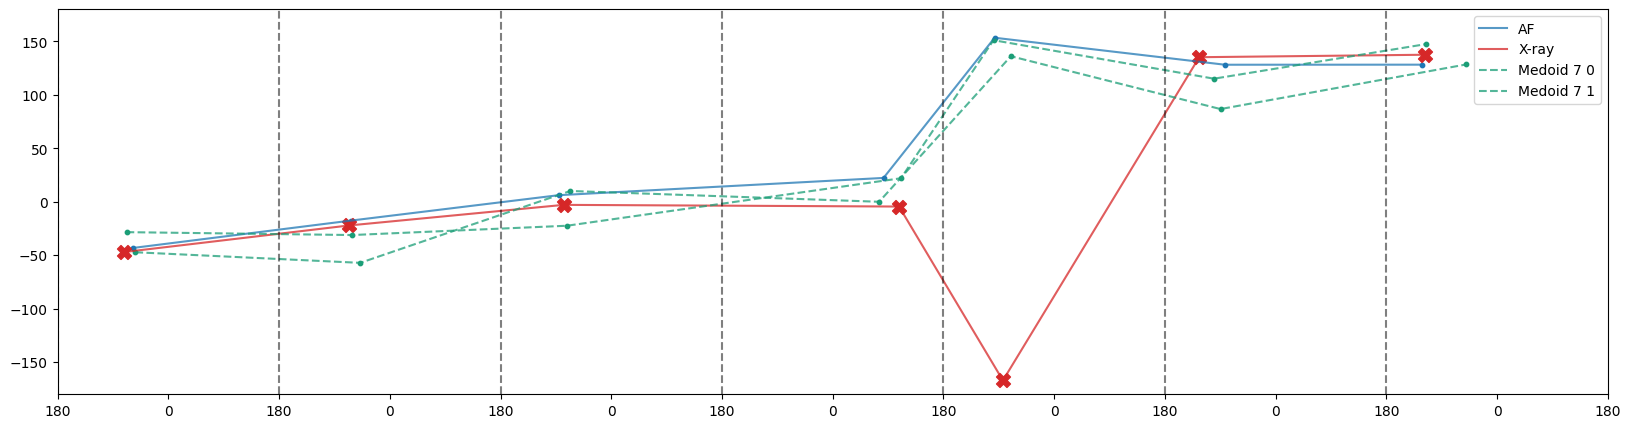

In [199]:
x_medoids, x_af, x_res, y = next(iter(train_dataloader))
# plot_ml(8, x_medoids, x_af, y, None, print_windows=[0,1,2])
plot_ml_single(8, x_medoids, x_af, y, None)

In [301]:
L = x_medoids.shape[-1] // 2
torch.arange(L) + get_offset(winsizes[-1]) - get_offset(L)

tensor([0, 1, 2, 3, 4, 5, 6])

In [324]:
def get_offset(L):
    if L % 2 == 0:
        return L // 2 - 1
    return L - L // 2 - 1
    
class SelfAttention(nn.Module):
    def __init__(self, d, nhead):
        super().__init__()
        self.mha = nn.MultiheadAttention(d, nhead, batch_first=True)
    def forward(self, x):
        return self.mha(x, x, x)[0]

class Block(nn.Module):
    def __init__(self, d, nhead, dropout=0.0):
        super().__init__()
        self.mha = SelfAttention(d, nhead)
        self.ln1 = nn.LayerNorm(d)
        self.ln2 = nn.LayerNorm(d)
        self.ffwd = nn.Sequential(
            nn.Linear(d, 2*d),
            nn.GELU(),
            nn.Linear(2*d, d),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Net(nn.Module):
    def __init__(self, x_lens, winsizes, device, n_classes=20):
        super().__init__()
        self.x_lens = x_lens
        self.winsizes = winsizes
        self.n_medoids = sum(x_lens[1:])
        self.af_input_size = sum([w*2 for w in winsizes])
        self.input_size = sum([l*w*2 for l,w in zip(x_lens, winsizes)])
        self.device = device

        self.d = 32
        nheads = 2

        # self.embs = nn.ModuleList([nn.Linear(w*2, self.d, bias=False) for w in winsizes[1:]])
        n_clusters = 2 # FOR WIN 7 ONLY
        self.pos_emb = nn.Embedding(winsizes[-1], self.d) # positional embedding for 7 (biggest window size) positions
        self.emb = nn.Linear(n_classes + 2*n_clusters, self.d)
        
        dropout = 0.15
        self.blocks = nn.Sequential(
            Block(self.d, nheads, dropout),
            # Block(self.d, nheads, dropout),
            # Block(self.d, nheads, dropout),
            # Block(self.d, nheads, dropout)
        )

        self.ln_f = nn.LayerNorm(self.d)
        self.out = nn.Linear(self.d, 2)

    def emb_mask(self, x_medoids):
        xs = [[] for _ in range(x_medoids[0].shape[0])] # batch size
        for i,x in enumerate(x_medoids[1:]):
            mask = torch.any(x, dim=2)
            for j,xi in enumerate(x):
                xs[j].append(self.embs[i](xi[mask[j]]))
        return torch.nested.nested_tensor([torch.cat(xi, dim=0) for xi in xs])

    def forward(self, x_medoids, x_res):
        # x = torch.cat([self.embs[i](x[:,:1]) for i,x in enumerate(x_medoids[1:])], dim=1) # one cluster for each window
        # x = torch.cat([self.embs[i](x) for i,x in enumerate(x_medoids[1:])], dim=1)
        N, C, L = x_medoids.shape
        x_res = nn.functional.one_hot(x_res, num_classes=20)
        x_medoids = x_medoids.transpose(-2,-1).reshape(N, 2, L // 2, C).transpose(-3,-2).flatten(-2,-1)
        x = torch.cat([x_res, x_medoids], dim=-1)

        L = L // 2
        pos = (torch.arange(L) + get_offset(self.winsizes[-1]) - get_offset(L)).to(self.device)
        pos = self.pos_emb(pos)
        
        x = self.emb(x) + pos
        
        x = self.blocks(x)
        x = self.out(x)
        return x
    
    def get_optimizer(model):
        decay_params = [p for n,p in model.named_parameters() if p.dim() >= 2]
        no_decay_params = [p for n,p in model.named_parameters() if p.dim() < 2]
        optimizer = torch.optim.AdamW([
            {'params': decay_params, 'weight_decay': 1e-5},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ], betas=(0.7, 0.999), lr=1e-4)
        return optimizer
    
class AngleMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y, reduce='mean'):
        def diff(x1, x2):
            d = torch.abs(x1 - x2)
            d = torch.minimum(d, 360-d)
            return d
        if reduce=='sum':
            return torch.sum(diff(x, y)**2)
        return torch.mean(diff(x, y)**2)

model = nn.DataParallel(Net(X_lens, winsizes, device)).to(device)
# model = Net(X_lens, winsizes, device).to(device)
criterion = AngleMSELoss().to(device)
optimizer = Net.get_optimizer(model)
torch.compile(model)
sum(p.numel() for p in model.parameters())

9698

In [354]:
x_medoids, x_af, x_res, y = next(iter(train_dataloader))
# x_medoids = [m.to(device) for m in x_medoids]
# x_af = [af.to(device) for af in x_af]
x_medoids = x_medoids.to(device)
x_res = x_res.to(device)
model(x_medoids, x_res).shape

torch.Size([512, 7, 2])

In [355]:
losses = [[],[]]
for epoch in range(200):
    train_losses = []
    model.train()
    for x_medoids, x_af, x_res, y in train_dataloader:
        x_medoids = x_medoids.to(device)
        x_res = x_res.to(device)
        y = y.to(device)
        N, L = y.shape
        y = y.view(N, 2, L // 2).transpose(-2,-1)
        optimizer.zero_grad()
        y_pred = model(x_medoids, x_res)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = sum(train_losses) / len(train_dataloader)

    if epoch % 5 == 0:
        losses[0].append(train_loss)
        test_losses = []
        model.eval()
        for x_medoids, x_af, x_res, y in test_dataloader:
            x_medoids = x_medoids.to(device)
            x_res = x_res.to(device)
            y = y.to(device)
            N, L = y.shape
            y = y.view(N, 2, L // 2).transpose(-2,-1)
            y_pred = model(x_medoids, x_res)
            loss = criterion(y_pred, y)
            test_losses.append(loss.item())
        test_loss = sum(test_losses) / len(test_dataloader)
        losses[1].append(test_loss)

        print(f'Epoch {epoch} | Train = {train_loss:6.2f}  | Test = {test_loss:4.2f}')
    else:
        print(f'Epoch {epoch} | Train = {train_loss:6.2f}')

plt.plot(losses[0], label='Train')
plt.plot(losses[1], label='Test')
plt.legend()
plt.ylim(0, 2000)

Epoch 0 | Train = 7635.68  | Test = 6789.27
Epoch 1 | Train = 5940.61
Epoch 2 | Train = 4208.73
Epoch 3 | Train = 2700.35
Epoch 4 | Train = 1801.57
Epoch 5 | Train = 1362.41  | Test = 1229.73
Epoch 6 | Train = 1151.57
Epoch 7 | Train = 1060.86
Epoch 8 | Train = 1018.22
Epoch 9 | Train = 992.52
Epoch 10 | Train = 973.26  | Test = 961.37
Epoch 11 | Train = 957.58
Epoch 12 | Train = 943.61
Epoch 13 | Train = 932.83
Epoch 14 | Train = 924.67
Epoch 15 | Train = 917.08  | Test = 913.01
Epoch 16 | Train = 910.95
Epoch 17 | Train = 904.57
Epoch 18 | Train = 897.82
Epoch 19 | Train = 891.48
Epoch 20 | Train = 884.91  | Test = 882.38
Epoch 21 | Train = 879.28
Epoch 22 | Train = 873.20
Epoch 23 | Train = 867.54
Epoch 24 | Train = 863.01
Epoch 25 | Train = 857.99  | Test = 857.32
Epoch 26 | Train = 853.34
Epoch 27 | Train = 848.61
Epoch 28 | Train = 844.47
Epoch 29 | Train = 841.18
Epoch 30 | Train = 837.57  | Test = 838.46
Epoch 31 | Train = 834.30
Epoch 32 | Train = 831.09
Epoch 33 | Train = 828

In [ ]:
plt.plot(losses[0], label='Train')
plt.plot(losses[1], label='Test')
plt.legend()
plt.ylim(0, 2000)

In [ ]:
test_losses = []
for x_medoids, x_af, x_res, y in test_dataloader:
    y = y.to(device)
    if torch.isnan(y).any():
        continue
    y_pred = model(x_medoids, x_af)
    loss = criterion(y_pred, y)
    test_losses.append(loss.item())
print('Test:', sum(test_losses) / len(test_dataloader))

In [ ]:
x_medoids, x_af, x_res, y = next(iter(dataloader))
pred = model(x_af).detach()
plot_ml(0, x_medoids, x_af, y, pred)

In [ ]:
pdbmine_loss = 0
af_loss = 0
old_model_loss = 0
for x_medoids, x_af, x_res, y in train_dataloader:
    af_loss += criterion(x_af[-1][:,[3,10]], y, False).item()
    pdbmine_loss += criterion(x_medoids[-1][:,0,[3,10]], y, False).item()
    old_model_loss += criterion(old_model(x_res, x_af[-1]), y, False).item()
print(af_loss / len(train_dataloader))
print(pdbmine_loss / len(train_dataloader))

pdbmine_loss = 0
af_loss = 0
for x_medoids, x_af, x_res, y in test_dataloader:
    af_loss += criterion(x_af[-1][:,[3,10]], y, False).item()
    pdbmine_loss += criterion(x_medoids[-1][:,0,[3,10]], y, False).item()
print(af_loss / len(test_dataloader))
print(pdbmine_loss / len(test_dataloader))

In [ ]:
embs = nn.ModuleList([nn.Linear(w*2, 128) for w in winsizes[1:]])
# x = torch.cat([embs[i](x) for i,x in enumerate(x_medoids[1:])], dim=1)
xs = [[] for _ in range(512)]
for i,x in enumerate(x_medoids[1:]):
    mask = torch.any(x, dim=2)
    for j,xi in enumerate(x):
        xs[j].append(embs[i](xi[mask[j]]))
x = torch.nested.nested_tensor([torch.cat(xi, dim=0) for xi in xs])